In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from fastai import *

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

%matplotlib inline

In [23]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y %m %d %H')

In [24]:
data = pd.read_csv('../data/pollution.csv',
                   parse_dates={'date': ['year','month','day','hour']},
                   date_parser=dateparse)

In [25]:
data.shape

(43824, 10)

In [26]:
data.head(5)

,date,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [27]:
data.drop('No', axis=1, inplace=True)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [28]:
data.head(5)

,date,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [29]:
data.columns = ['date','polution','dew','temp','press','wnd_dir','wnd_spd','snow','rain']

In [30]:
data.dtypes

date        datetime64[ns]
polution           float64
dew                  int64
temp               float64
press              float64
wnd_dir             object
wnd_spd            float64
snow                 int64
rain                 int64
dtype: object

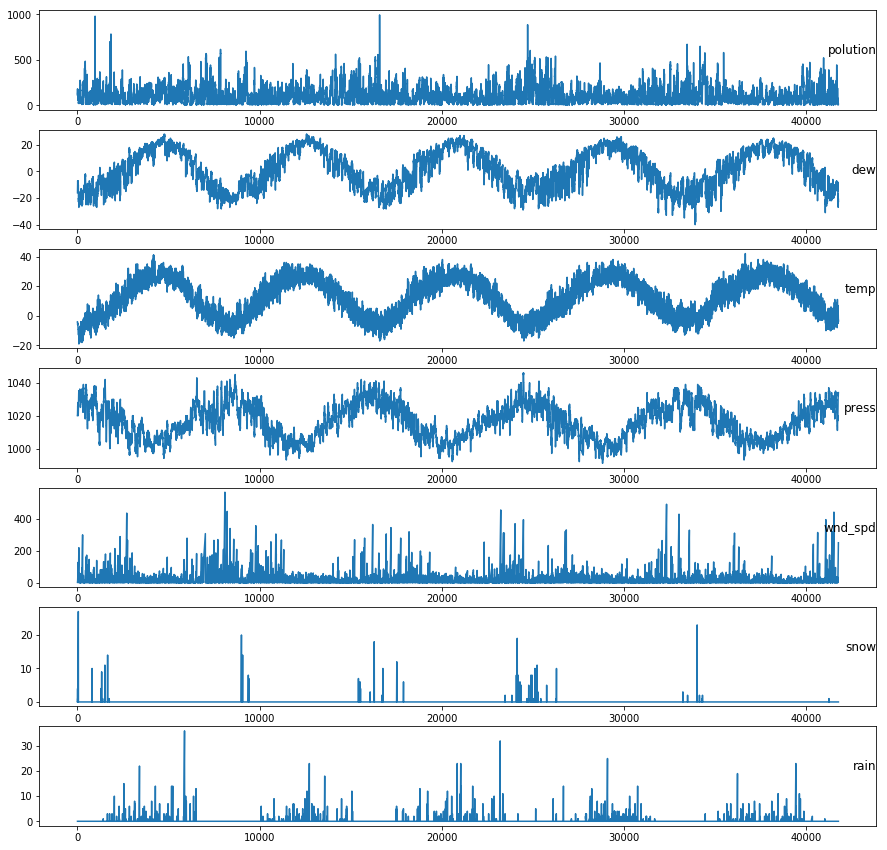

In [31]:
plt.figure(figsize=(15,15))
num_features = data.select_dtypes(['float64','int64']).columns
n_features = len(num_features)
i = 1
for feature in num_features:
    plt.subplot(n_features, 1, i)
    plt.plot(data[feature])
    plt.title(feature, y=0.5, loc='right')
    i += 1

In [32]:
target = data['polution']
data.drop('polution', axis=1, inplace=True)

In [33]:
data = data.shift(-1)
data['pol(t-1)'] = target.shift(-1)
data = pd.concat([data, target], axis=1)
data.dropna(inplace=True)
data.set_index('date', inplace=True)

In [34]:
n_train = 365 * 24
train_data = data.iloc[:n_train, :]
test_data = data.iloc[n_train:, :]

In [35]:
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]

X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [36]:
cat_cols = X_train.select_dtypes('object').columns
num_cols = X_train.select_dtypes('float64').columns

In [37]:
X_train.shape, X_test.shape

((8760, 8), (32996, 8))

In [38]:
label_encoder = LabelEncoder()
scaler = MinMaxScaler(feature_range=(0,1))

In [39]:
X_train[cat_cols] = label_encoder.fit_transform(np.ravel(X_train[cat_cols]))
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

X_test[cat_cols] = label_encoder.transform(np.ravel(X_test[cat_cols]))
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [40]:
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [41]:
X_train.shape, X_test.shape

((8760, 1, 8), (32996, 1, 8))

In [44]:
class MV_LSTM(torch.nn.Module):
    def __init__(self, n_features, seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 50  # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)

        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 1)


    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)


    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [45]:
n_features = X_train.shape[2] # this is number of parallel inputs
n_timesteps = X_train.shape[1] # this is number of timesteps

# create NN
mv_net = MV_LSTM(n_features, n_timesteps)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-3)

train_episodes = 500
batch_size = 72

In [53]:
for t in range(train_episodes):
    mv_net.train()
    for b in range(0,len(X_train),batch_size):
        inpt = X_train[b:b+batch_size,:,:]
        target = y_train[b:b+batch_size]    

        x_batch = torch.tensor(inpt,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)

        mv_net.init_hidden(x_batch.size(0))
    #    lstm_out, _ = mv_net.l_lstm(x_batch,nnet.hidden)    
    #    lstm_out.contiguous().view(x_batch.size(0),-1)
        output = mv_net(x_batch) 
        loss = torch.sqrt(criterion(output.view(-1), y_batch))

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad()
    mv_net.eval()
    
    inpt = X_test[b:b+batch_size,:,:]
    target = y_test[b:b+batch_size]   
    
    x_batch = torch.tensor(inpt,dtype=torch.float32)    
    y_batch = torch.tensor(target,dtype=torch.float32)
    
    mv_net.init_hidden(x_batch.size(0))
    
    output = mv_net(x_batch)
    eval_loss = torch.sqrt(criterion(output.view(-1), y_batch))
    print('step:', t, 'traning loss: ' , loss.item(), ' validation loss : ' , eval_loss.item())

step: 0 traning loss:  23.07223129272461  validation loss :  193.90806579589844
step: 1 traning loss:  17.656917572021484  validation loss :  186.76422119140625
step: 2 traning loss:  13.465944290161133  validation loss :  179.6146697998047
step: 3 traning loss:  12.890605926513672  validation loss :  173.7022247314453
step: 4 traning loss:  15.003934860229492  validation loss :  168.71530151367188
step: 5 traning loss:  18.179611206054688  validation loss :  164.39707946777344
step: 6 traning loss:  21.582029342651367  validation loss :  160.58831787109375
step: 7 traning loss:  24.903663635253906  validation loss :  157.1917724609375
step: 8 traning loss:  28.036876678466797  validation loss :  154.14271545410156
step: 9 traning loss:  30.946115493774414  validation loss :  151.39430236816406
step: 10 traning loss:  33.622291564941406  validation loss :  148.9110565185547
step: 11 traning loss:  36.06547546386719  validation loss :  146.6650848388672
step: 12 traning loss:  38.277236

step: 201 traning loss:  9.01226806640625  validation loss :  24.56829071044922
step: 202 traning loss:  9.010613441467285  validation loss :  24.56376075744629
step: 203 traning loss:  9.008966445922852  validation loss :  24.559688568115234
step: 204 traning loss:  9.007335662841797  validation loss :  24.556053161621094
step: 205 traning loss:  9.005709648132324  validation loss :  24.552852630615234
step: 206 traning loss:  9.00409984588623  validation loss :  24.550064086914062
step: 207 traning loss:  9.002500534057617  validation loss :  24.547683715820312
step: 208 traning loss:  9.000917434692383  validation loss :  24.54568862915039
step: 209 traning loss:  8.999349594116211  validation loss :  24.544076919555664
step: 210 traning loss:  8.997794151306152  validation loss :  24.54283332824707
step: 211 traning loss:  8.996260643005371  validation loss :  24.54194450378418
step: 212 traning loss:  8.994736671447754  validation loss :  24.541400909423828
step: 213 traning loss:

step: 401 traning loss:  8.95810317993164  validation loss :  25.1506290435791
step: 402 traning loss:  8.958237648010254  validation loss :  25.149585723876953
step: 403 traning loss:  8.958357810974121  validation loss :  25.148540496826172
step: 404 traning loss:  8.958473205566406  validation loss :  25.147497177124023
step: 405 traning loss:  8.958579063415527  validation loss :  25.146453857421875
step: 406 traning loss:  8.958677291870117  validation loss :  25.145416259765625
step: 407 traning loss:  8.958770751953125  validation loss :  25.144384384155273
step: 408 traning loss:  8.958855628967285  validation loss :  25.14335823059082
step: 409 traning loss:  8.958930969238281  validation loss :  25.142332077026367
step: 410 traning loss:  8.958993911743164  validation loss :  25.141326904296875
step: 411 traning loss:  8.959050178527832  validation loss :  25.14031982421875
step: 412 traning loss:  8.959097862243652  validation loss :  25.139320373535156
step: 413 traning los